In [1]:
datasetName = 'brain_FetalBrain4_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_FetalBrain4_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalBrain_4.CTCGCAGCGTCCATGGCG,FetalBrain_4.GAATTAGATCTTCTGTGT,FetalBrain_4.CTCCATTAGAGAGTCGGT,FetalBrain_4.CCGCTATAGAGAGCAGGA,FetalBrain_4.TTCATAAGGGTCGCCCTC
,<int>,<int>,<int>,<int>,<int>
A1BG,0,1,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,0,0,0,0,0
A2M-AS1,0,0,0,0,0
A2MP1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalBrain_4.CTCGCAGCGTCCATGGCG,brain,FetalBrain,FetalBrain,normal,Donor9,female,11 week old
FetalBrain_4.GAATTAGATCTTCTGTGT,brain,FetalBrain,FetalBrain,normal,Donor9,female,11 week old
FetalBrain_4.CTCCATTAGAGAGTCGGT,brain,FetalBrain,FetalBrain,normal,Donor9,female,11 week old
FetalBrain_4.CCGCTATAGAGAGCAGGA,brain,FetalBrain,FetalBrain,normal,Donor9,female,11 week old
FetalBrain_4.TTCATAAGGGTCGCCCTC,brain,FetalBrain,FetalBrain,normal,Donor9,female,11 week old


[1] Fetal neuron         Fetal endocrine cell Fetal neuron        
[4] Fetal neuron         <NA>                
20 Levels: Antigen presenting cell (RPS high) Astrocyte B cell ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


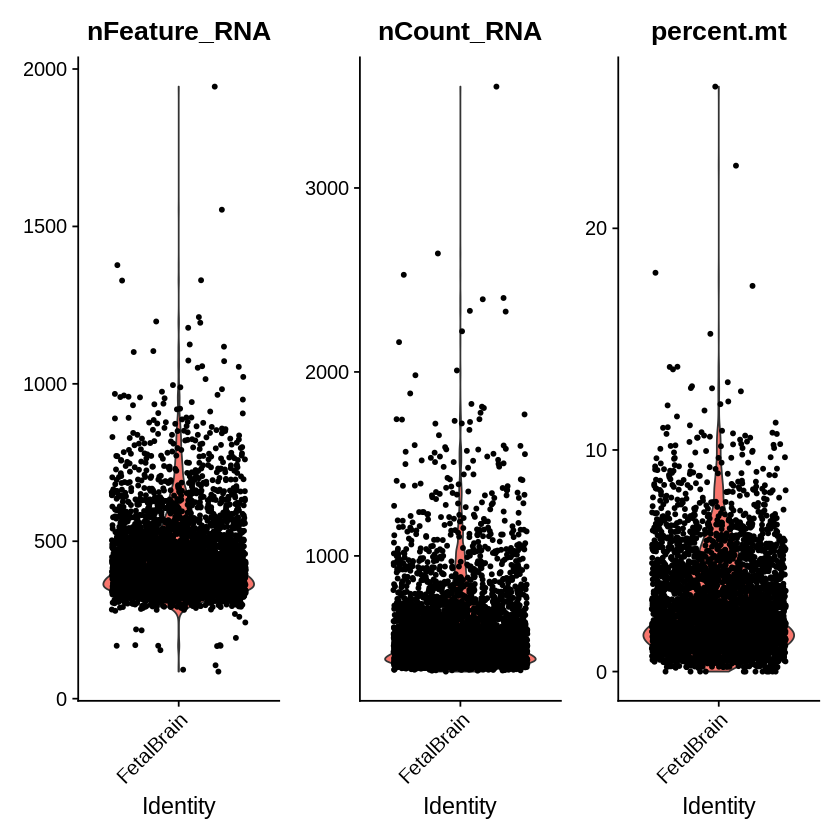

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  TUBA1A, UCHL1, STMN2, TMSB10, GAP43, STMN1, PTMA, C1orf61, FABP7, STMN4 
	   CALM2, GPM6B, PTN, HMGCS1, NNAT, CSRP2, PAX6, NSG1, CRABP1, RPL7 
	   NEUROD1, GNG3, HMGB2, TMEM161B-AS1, RPS3A, SRP14, SCG5, HMP19, C21orf59, DCLK1 
Negative:  SPP1, AIF1, A2M, CCL3, VSIG4, CCL3L3, FTL, FCER1G, SRGN, TYROBP 
	   C1QB, TREM2, CD36, LAPTM5, CD53, RGS1, CCL4, FOLR2, ARHGDIB, FPR1 
	   CX3CR1, C1QC, P2RY12, ALOX5AP, CTSB, APOC1, GPR34, C1QA, CCL4L2, HPGDS 
PC_ 2 
Positive:  STMN2, TUBA1A, GAP43, STMN1, TMSB10, TMSB4X, PTMA, UCHL1, CALM2, GNG3 
	   UBE2C, NEUROD1, CKS2, KPNA2, NUSAP1, STMN4, MAD2L1, HMP19, TUBA1C, PAX6 
	   CCNB1, PTTG1, HMGB2, CCNB2, ARL6IP1, MAB21L1, C21orf59, NSG1, TUBA1B, TOP2A 
Negative:  DCN, COL3A1, COL1A2, ISLR, IFITM3, LUM, PTN, SPARC, OGN, PTGDS 
	   COL1A1, FN1, SLC6A13, ANXA2, ATP1A2, IFITM1, LGALS1, VCAN, LRRC17, CYP1B1 
	   SLC7A11, NID1, SPARCL1, VIM, GJA1, IFITM2, APOD, S100A11, COLEC12, GLT8D2 
PC_ 3 
Positive:  C1orf61, FABP7, EDNRB, NTRK2, PTPR

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


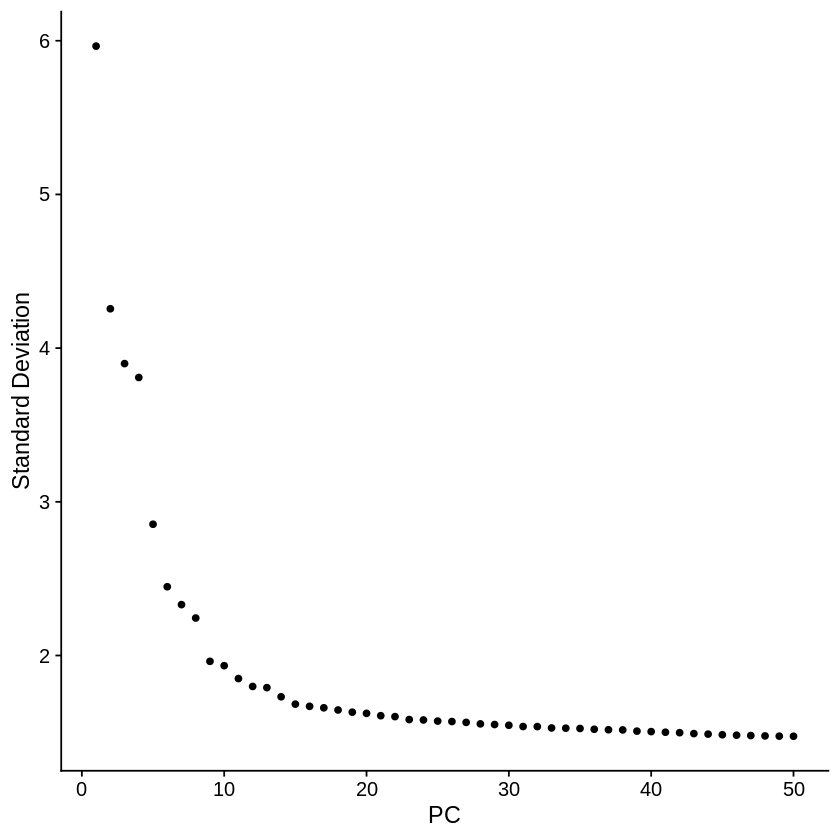

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [10]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
03:44:20 UMAP embedding parameters a = 0.9922 b = 1.112

03:44:20 Read 3880 rows and found 10 numeric columns

03:44:20 Using Annoy for neighbor search, n_neighbors = 30

03:44:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

03:44:21 Writing NN index file to temp file /tmp/RtmpjA74IG/file428c1bfe5fc

03:44:21 Searching Annoy index using 1 thread, search_k = 3000

03:44:22 Annoy recall = 100%

03:44:22 Commencing smooth kNN distance calibration using 1 thread

03:44:23 Initializing fro

In [16]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3880
Number of edges: 128203

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8476
Number of communities: 9
Elapsed time: 0 seconds


03:44:59 UMAP embedding parameters a = 0.9922 b = 1.112

03:44:59 Read 3880 rows and found 10 numeric columns

03:44:59 Using Annoy for neighbor search, n_neighbors = 30

03:44:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

03:45:00 Writing NN index file to temp file /tmp/RtmpjA74IG/file428c624181f1

03:45:00 Searching Annoy index using 1 thread, search_k = 3000

03:45:01 Annoy recall = 100%

03:45:01 Commencing smooth kNN distance calibration using 1 thread

03:45:02 Initializing from normalized Laplacian + noise

03:45:02 Commencing optimization for 500 epochs, with 162362 positive edges

03:45:11 Optimization finished



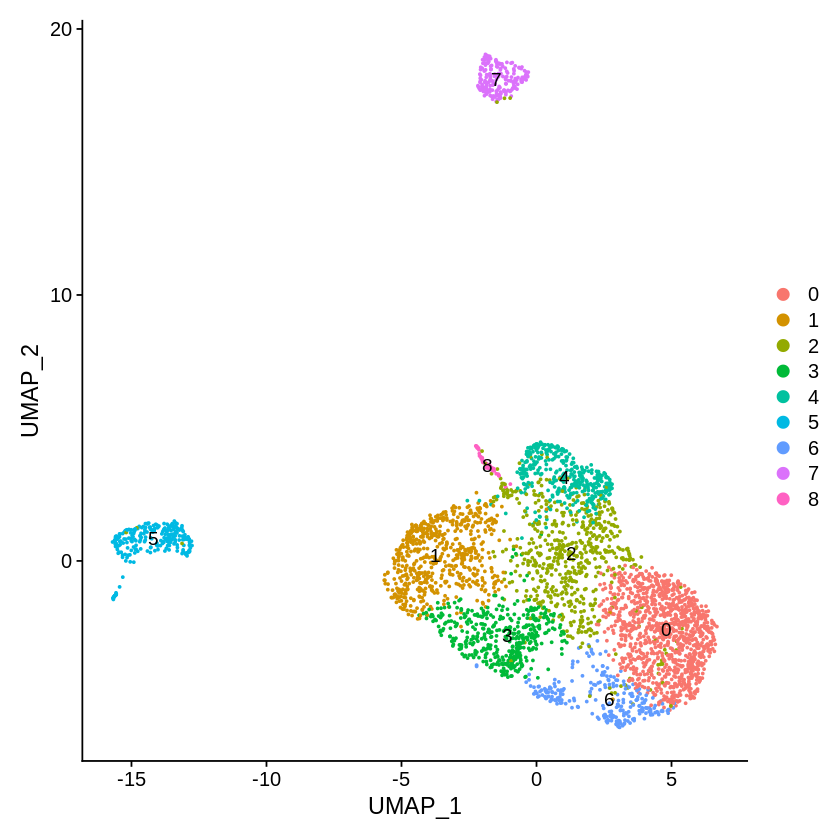

In [17]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [18]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

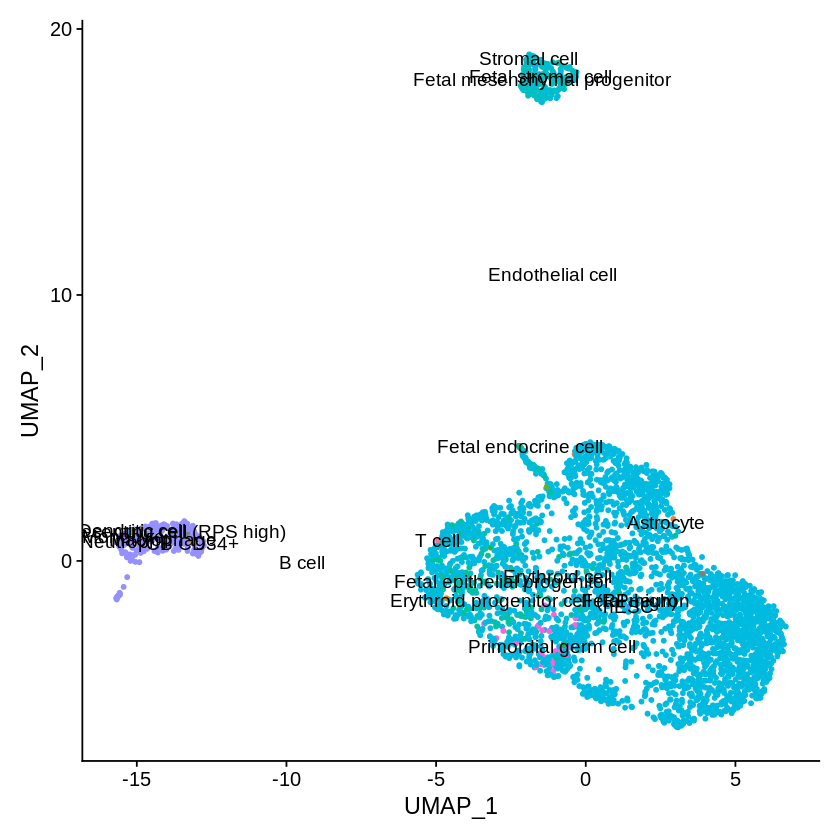

In [19]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [20]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [21]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [22]:
new.cluster.ids <- c('Brain-Nerve tissue-Neuron-GAP43', 'Proliferating cell-CDK1', 'Brain-Nerve tissue-Oligodendrocyte-PTN', 
                    'Unknown', 'Brain-Nerve tissue-Oligodendrocyte-PTN', 'Brain-Nerve tissue-Microglia-AIF1',
                    'Brain-Nerve tissue-Neuron-GAP43', 'Brain-Nerve tissue-Oligodendrocyte-PTN', 'Brain-Nerve tissue-Ependymal cell-TTR')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [12]:
new.cluster.ids <- c('Brain-Nerve tissue-Neuron-GAP43', 'Proliferating cell-CDK1', 'Brain-Nerve tissue-Oligodendrocyte-PTN', 
                    'Unknown', 'Brain-Nerve tissue-Oligodendrocyte-PTN', 'Brain-Nerve tissue-Microglia-AIF1',
                    'Brain-Nerve tissue-Neuron-GAP43', 'Brain-Nerve tissue-Oligodendrocyte-PTN', 'Brain-Nerve tissue-Ependymal cell-TTR')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

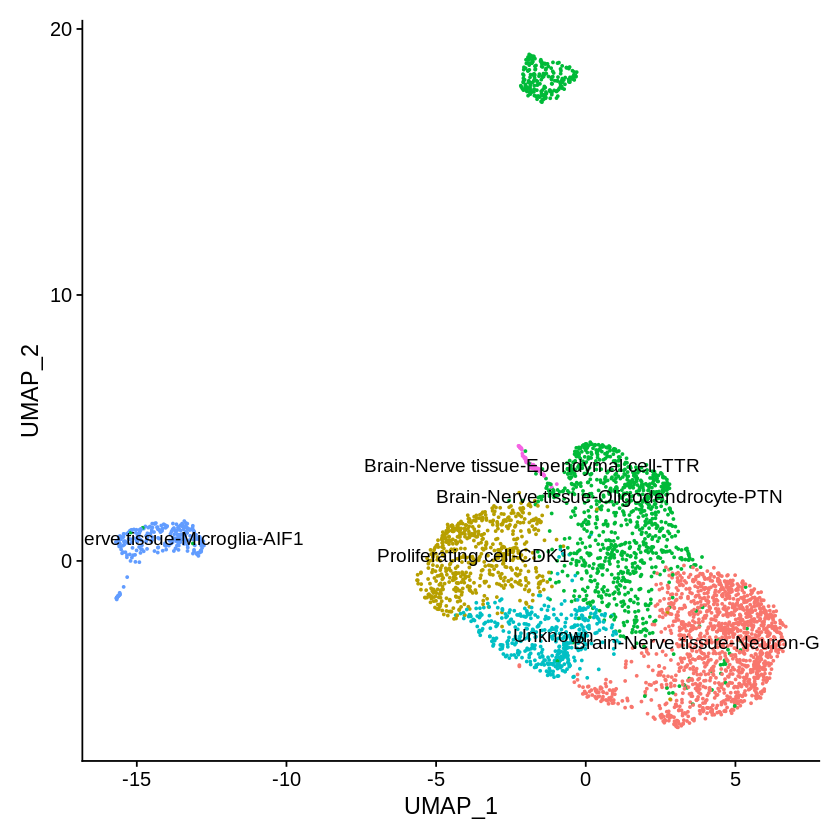

In [23]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [24]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [25]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))